In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('D:RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

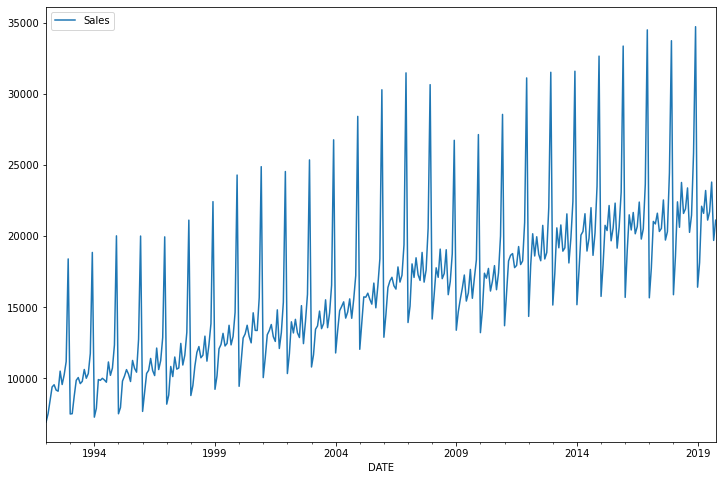

In [5]:
df.plot(figsize=(12,8))

## Train Test Split

In [6]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.

In [7]:
len(df)- 18

316

In [8]:
test_size = 18

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [12]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [19]:
# What does the first batch look like?
X,y = generator[0]

In [20]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
# We're only using one feature in our time series
n_features = 1

In [23]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [27]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [28]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

<ipython-input-28-3878a3328f67>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


Epoch 1/20
304/304 [==============================] - 8s 14ms/step - loss: 0.0255 - val_loss: 0.0109
Epoch 2/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0183 - val_loss: 0.0060
Epoch 3/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0139 - val_loss: 0.0012
Epoch 4/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 5/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0025 - val_loss: 0.0058


In [29]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

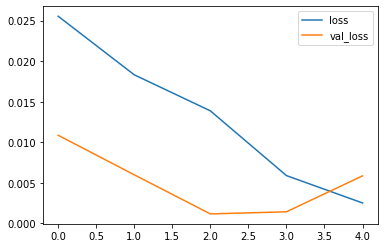

In [30]:
losses.plot()

In [31]:
first_eval_batch = scaled_train[-length:]

In [34]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))
#n_input=length

In [35]:
model.predict(first_eval_batch)

array([[0.58328104]], dtype=float32)

In [36]:
scaled_test[0]

array([0.61087714])

In [37]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [38]:
true_predictions = scaler.inverse_transform(test_predictions)

In [39]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

<ipython-input-39-53e06c23926f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [40]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,23003.892971
2018-06-01,21589,21742.014112
2018-07-01,21919,22021.866874
2018-08-01,23381,24211.879734
2018-09-01,20260,21345.963186
2018-10-01,21473,22042.199952
2018-11-01,25831,26781.724669
2018-12-01,34706,41265.689403
2019-01-01,16410,17942.699290


<AxesSubplot:xlabel='DATE'>

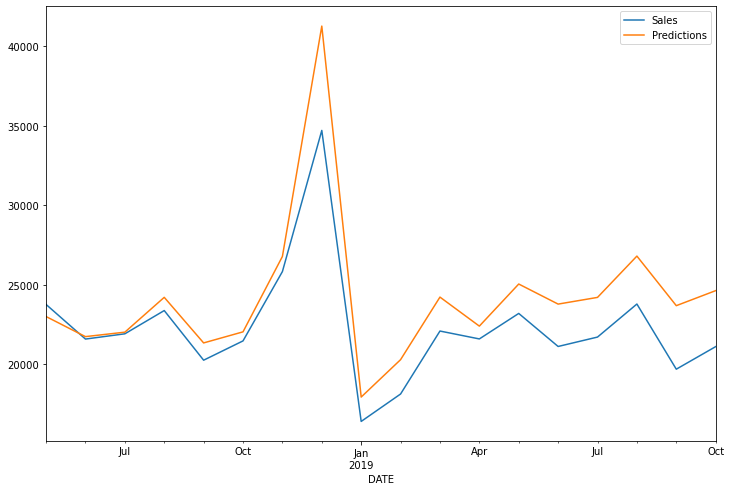

In [41]:
test.plot(figsize=(12,8))

In [42]:
#Retrain and Forecasting

In [43]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [44]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [45]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

<ipython-input-45-74a9761509e5>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


Epoch 1/8
322/322 [==============================] - 7s 12ms/step - loss: 0.0228
Epoch 2/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0156
Epoch 3/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0087
Epoch 4/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0046
Epoch 5/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0028
Epoch 6/8
322/322 [==============================] - 4s 13ms/step - loss: 0.0016: 0s - loss:
Epoch 7/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0021
Epoch 8/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0018


In [46]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [47]:
forecast = scaler.inverse_transform(forecast)

In [48]:
#Creating new timestamp index with pandas

In [49]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [50]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [51]:
forcast_i=pd.date_range(start='2019-11-01',periods=periods,freq='W')
forcast_i
#W for weekly frequency
#M month end frequency-each Monday
#MS month start frequency
#B business day frequency-except holiday-sat,sun
#D  day frequency-day wise
#A  annual end day frequency-31 december
#BAS business annual start frequency-1st day of year
#BA business annual end frequency-1st day of year
#H-hourly
#S-second

DatetimeIndex(['2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
               '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22',
               '2019-12-29', '2020-01-05', '2020-01-12', '2020-01-19'],
              dtype='datetime64[ns]', freq='W-SUN')

In [52]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [53]:
forecast_df

,Forecast
2019-11-01,25537.241796
2019-12-01,36081.209301
2020-01-01,16603.441454
2020-02-01,18297.575117
2020-03-01,21938.677742
2020-04-01,21545.754351
2020-05-01,23023.475769
2020-06-01,21218.758728
2020-07-01,21786.695989
2020-08-01,23644.067246


<AxesSubplot:>

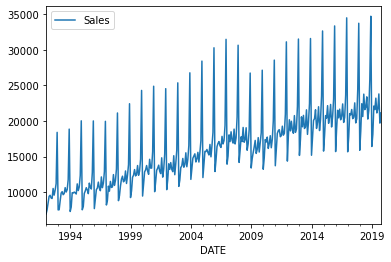

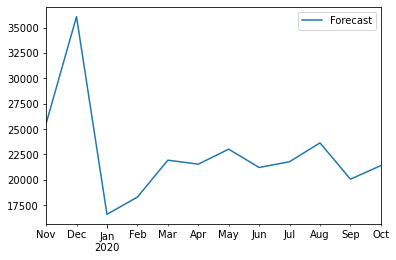

In [54]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

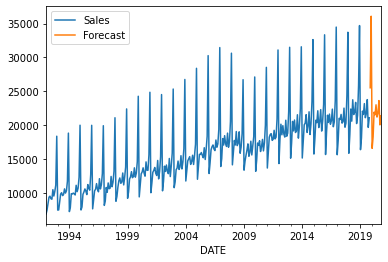

In [55]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

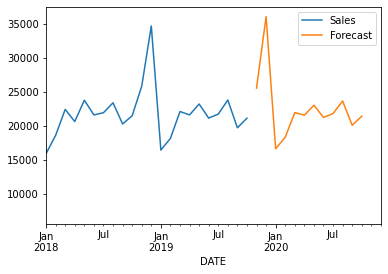

In [56]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')